### Mount Google Drive

In [ ]:
import collections

Mounted at /content/drive


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
!cat /proc/meminfo

MemTotal:       13333568 kB
MemFree:         2150484 kB
MemAvailable:   10901136 kB
Buffers:           96924 kB
Cached:          7447040 kB
SwapCached:            0 kB
Active:          2680348 kB
Inactive:        7998460 kB
Active(anon):    1792928 kB
Inactive(anon):    14696 kB
Active(file):     887420 kB
Inactive(file):  7983764 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               264 kB
Writeback:             0 kB
AnonPages:       3134844 kB
Mapped:          1470800 kB
Shmem:             15360 kB
Slab:             259564 kB
SReclaimable:     204704 kB
SUnreclaim:        54860 kB
KernelStack:        4920 kB
PageTables:        16612 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666784 kB
Committed_AS:    6203576 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1048 kB
AnonHugePages:   

### Import Dataset

In [ ]:
import keras, os
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.layers import Dropout
import tensorflow as tf

In [ ]:
tf.test.gpu_device_name()

/device:GPU:0


In [ ]:
train_gen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, rotation_range=15, horizontal_flip = True, shear_range = 0.2)
test_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
path = '/pneumonia_covid19_classification/dataset_balanced'
train_data = train_gen.flow_from_directory(path + '/train', target_size=(299,299),batch_size=64,class_mode='categorical',shuffle=True)
test_data = test_gen.flow_from_directory(path +'/test', target_size=(299,299),batch_size=64,class_mode='categorical',shuffle=True)

Found 1818 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


### Convert Data Label

In [ ]:
from keras.utils.np_utils import to_categorical 
print(train_data.class_indices)
num_classes = len(train_data.class_indices)
train_labels = train_data.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
print(test_data.class_indices)
num_classes = len(test_data.class_indices)
test_labels = test_data.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


### Create InceptionResNetV2 Model

In [ ]:
from keras.applications import InceptionResNetV2
from keras.optimizers import Adam

In [ ]:
def create_InceptionResNetV2():
  incepResNet = InceptionResNetV2(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
  #freeze all layers
  for layer in incepResNet.layers:
    layer.trainable = False
  x = incepResNet.output
  x = AveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(64,activation='relu')(x)
  x = Dropout(0.3)(x)
  final_layer = Dense(3,activation='softmax')(x)
  model = Model(inputs=incepResNet.input, outputs=final_layer)
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
model = create_InceptionResNetV2()

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Callbacks (Tensorboard and ModelCheckpoint)

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
# %load_ext tensorboard

checkpoint_filepath = '/pneumonia_covid19_classification/InceptionResNetV2/logs/V1'
log_dir = '/pneumonia_covid19_classification/InceptionResNetV2/logs'
CSV_training_logdir = '/pneumonia_covid19_classification/InceptionResNetV2/logs_finetune/training_log.csv'

my_callbacks = [
    ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True),

    TensorBoard(log_dir=log_dir, histogram_freq=1),
    
    CSVLogger(CSV_training_logdir)
]

### Train

In [ ]:
initial_epoch = 15

In [ ]:
incepRes_model = model.fit(train_data, validation_data=test_data, 
                      epochs=initial_epoch, 
                      steps_per_epoch=None, 
                      validation_steps=None,
                      callbacks=my_callbacks)

Epoch 1/15
 1/29 [>.............................] - ETA: 0s - loss: 1.2405 - accuracy: 0.2969WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 622s 21s/step - loss: 2.9886 - accuracy: 0.7052 - val_loss: 0.2911 - val_accuracy: 0.9083
Epoch 2/15
29/29 [==============================] - 109s 4s/step - loss: 0.2842 - accuracy: 0.9147 - val_loss: 0.1593 - val_accuracy: 0.9500
Epoch 3/15
29/29 [==============================] - 108s 4s/step - loss: 0.2073 - accuracy: 0.9318 - val_loss: 0.2596 - val_accuracy: 0.9062
Epoch 4/15
29/29 [==============================] - 108s 4s/step - loss: 0.1612 - accuracy: 0.9488 - val_loss: 0.1165 - val_accuracy: 0.9688
Epoch 5/15
29/29 [==============================] - 107s 4s/step - loss: 0.

### Load ModelCheckpoint

In [ ]:
model.load_weights('/pneumonia_covid19_classification/InceptionResNetV2/logs/V1')

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
from time import time
infer_time = []

In [ ]:
num_of_test_samples = 480 
batch_size = 64
test_data.shuffle = False
# t0 = time()
Y_pred = model.predict(test_data, num_of_test_samples // batch_size+1)
# end = time()
# infer_time.append(round((end-t0),5))
# print('Average time is {}'.format(infer_time/160))
# y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print(infer_time)

[260.26927]


In [ ]:
# from time import time
# infer_time = []
# t0 = time()
# yy_pred = model.predict(im.reshape((1,299,299,3)))
# infer_time.append((time()-t0)*1000)
# print('average time is {} ms'.format(np.average(np.asarray(infer_time))))
# print(yy_pred)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))
print(f'Accuracy: {accuracy_score(test_data.classes, y_pred)}')

Confusion Matrix
[[158   1   1]
 [  1 154   5]
 [  1   5 154]]
Classification Report
              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99       160
      NORMAL       0.96      0.96      0.96       160
   PNEUMONIA       0.96      0.96      0.96       160

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480

Accuracy: 0.9708333333333333


### Fine Tuning

In [ ]:
#unfreeze all layers
model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  784


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Let's take a look at the base model architecture
model.summary()
len(model.trainable_variables)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

179

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epoch + fine_tune_epochs
# print(incepRes_model.epoch)

Callbacks - Finetune

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger

checkpoint_filepath = '/pneumonia_covid19_classification/InceptionResNetV2/logs_finetune/V1_finetune'
log_dir = '/pneumonia_covid19_classification/InceptionResNetV2/logs_finetune'

my_fine_callbacks = [
    ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True),
]

In [ ]:
incepRes_model_fine = model.fit(train_data, validation_data=test_data, 
                      epochs=total_epochs, 
                      steps_per_epoch=None, 
                      validation_steps=None,
                      initial_epoch=incepRes_model.epoch[-1] + 1,
                      callbacks=my_fine_callbacks)

Epoch 16/30
29/29 [==============================] - 116s 4s/step - loss: 0.2556 - accuracy: 0.9125 - val_loss: 0.2088 - val_accuracy: 0.9271
Epoch 17/30
29/29 [==============================] - 113s 4s/step - loss: 0.1060 - accuracy: 0.9631 - val_loss: 0.1766 - val_accuracy: 0.9396
Epoch 18/30
29/29 [==============================] - 112s 4s/step - loss: 0.0792 - accuracy: 0.9719 - val_loss: 0.1480 - val_accuracy: 0.9563
Epoch 19/30
29/29 [==============================] - 111s 4s/step - loss: 0.0688 - accuracy: 0.9747 - val_loss: 0.1127 - val_accuracy: 0.9604
Epoch 20/30
29/29 [==============================] - 109s 4s/step - loss: 0.0490 - accuracy: 0.9868 - val_loss: 0.1276 - val_accuracy: 0.9646
Epoch 21/30
29/29 [==============================] - 113s 4s/step - loss: 0.0489 - accuracy: 0.9818 - val_loss: 0.1237 - val_accuracy: 0.9688
Epoch 22/30
29/29 [==============================] - 111s 4s/step - loss: 0.0317 - accuracy: 0.9890 - val_loss: 0.1069 - val_accuracy: 0.9792
Epoch 

### Confusion Matrix (FineTune)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
model.load_weights('/pneumonia_covid19_classification/InceptionResNetV2/logs_finetune/V1_finetune')

In [ ]:
num_of_test_samples = 480
batch_size = 64
test_data.shuffle = False
Y_pred = model.predict_generator(test_data, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

Instructions for updating:
Please use Model.predict, which supports generators.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
print(classification_report(test_data.classes, y_pred, target_names=target_names))
print(f'Accuracy: {accuracy_score(test_data.classes, y_pred)}')

Confusion Matrix
[[156   3   1]
 [  0 159   1]
 [  0   4 156]]
Classification Report
              precision    recall  f1-score   support

     COVID19       1.00      0.97      0.99       160
      NORMAL       0.96      0.99      0.98       160
   PNEUMONIA       0.99      0.97      0.98       160

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480

Accuracy: 0.98125


### Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
acc1 = incepRes_model.history['accuracy']
acc = acc1 + incepRes_model_fine.history['accuracy'][1:]
val_acc1 = incepRes_model.history['val_accuracy']
val_acc = val_acc1 + incepRes_model_fine.history['val_accuracy'][1:]

loss1 = incepRes_model.history['loss']
loss = loss1 + incepRes_model_fine.history['loss'][1:]
val_loss1 = incepRes_model.history['val_loss']
val_loss = val_loss1 + incepRes_model_fine.history['val_loss'][1:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Unrecognized location 'middle right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  del sys.path[0]


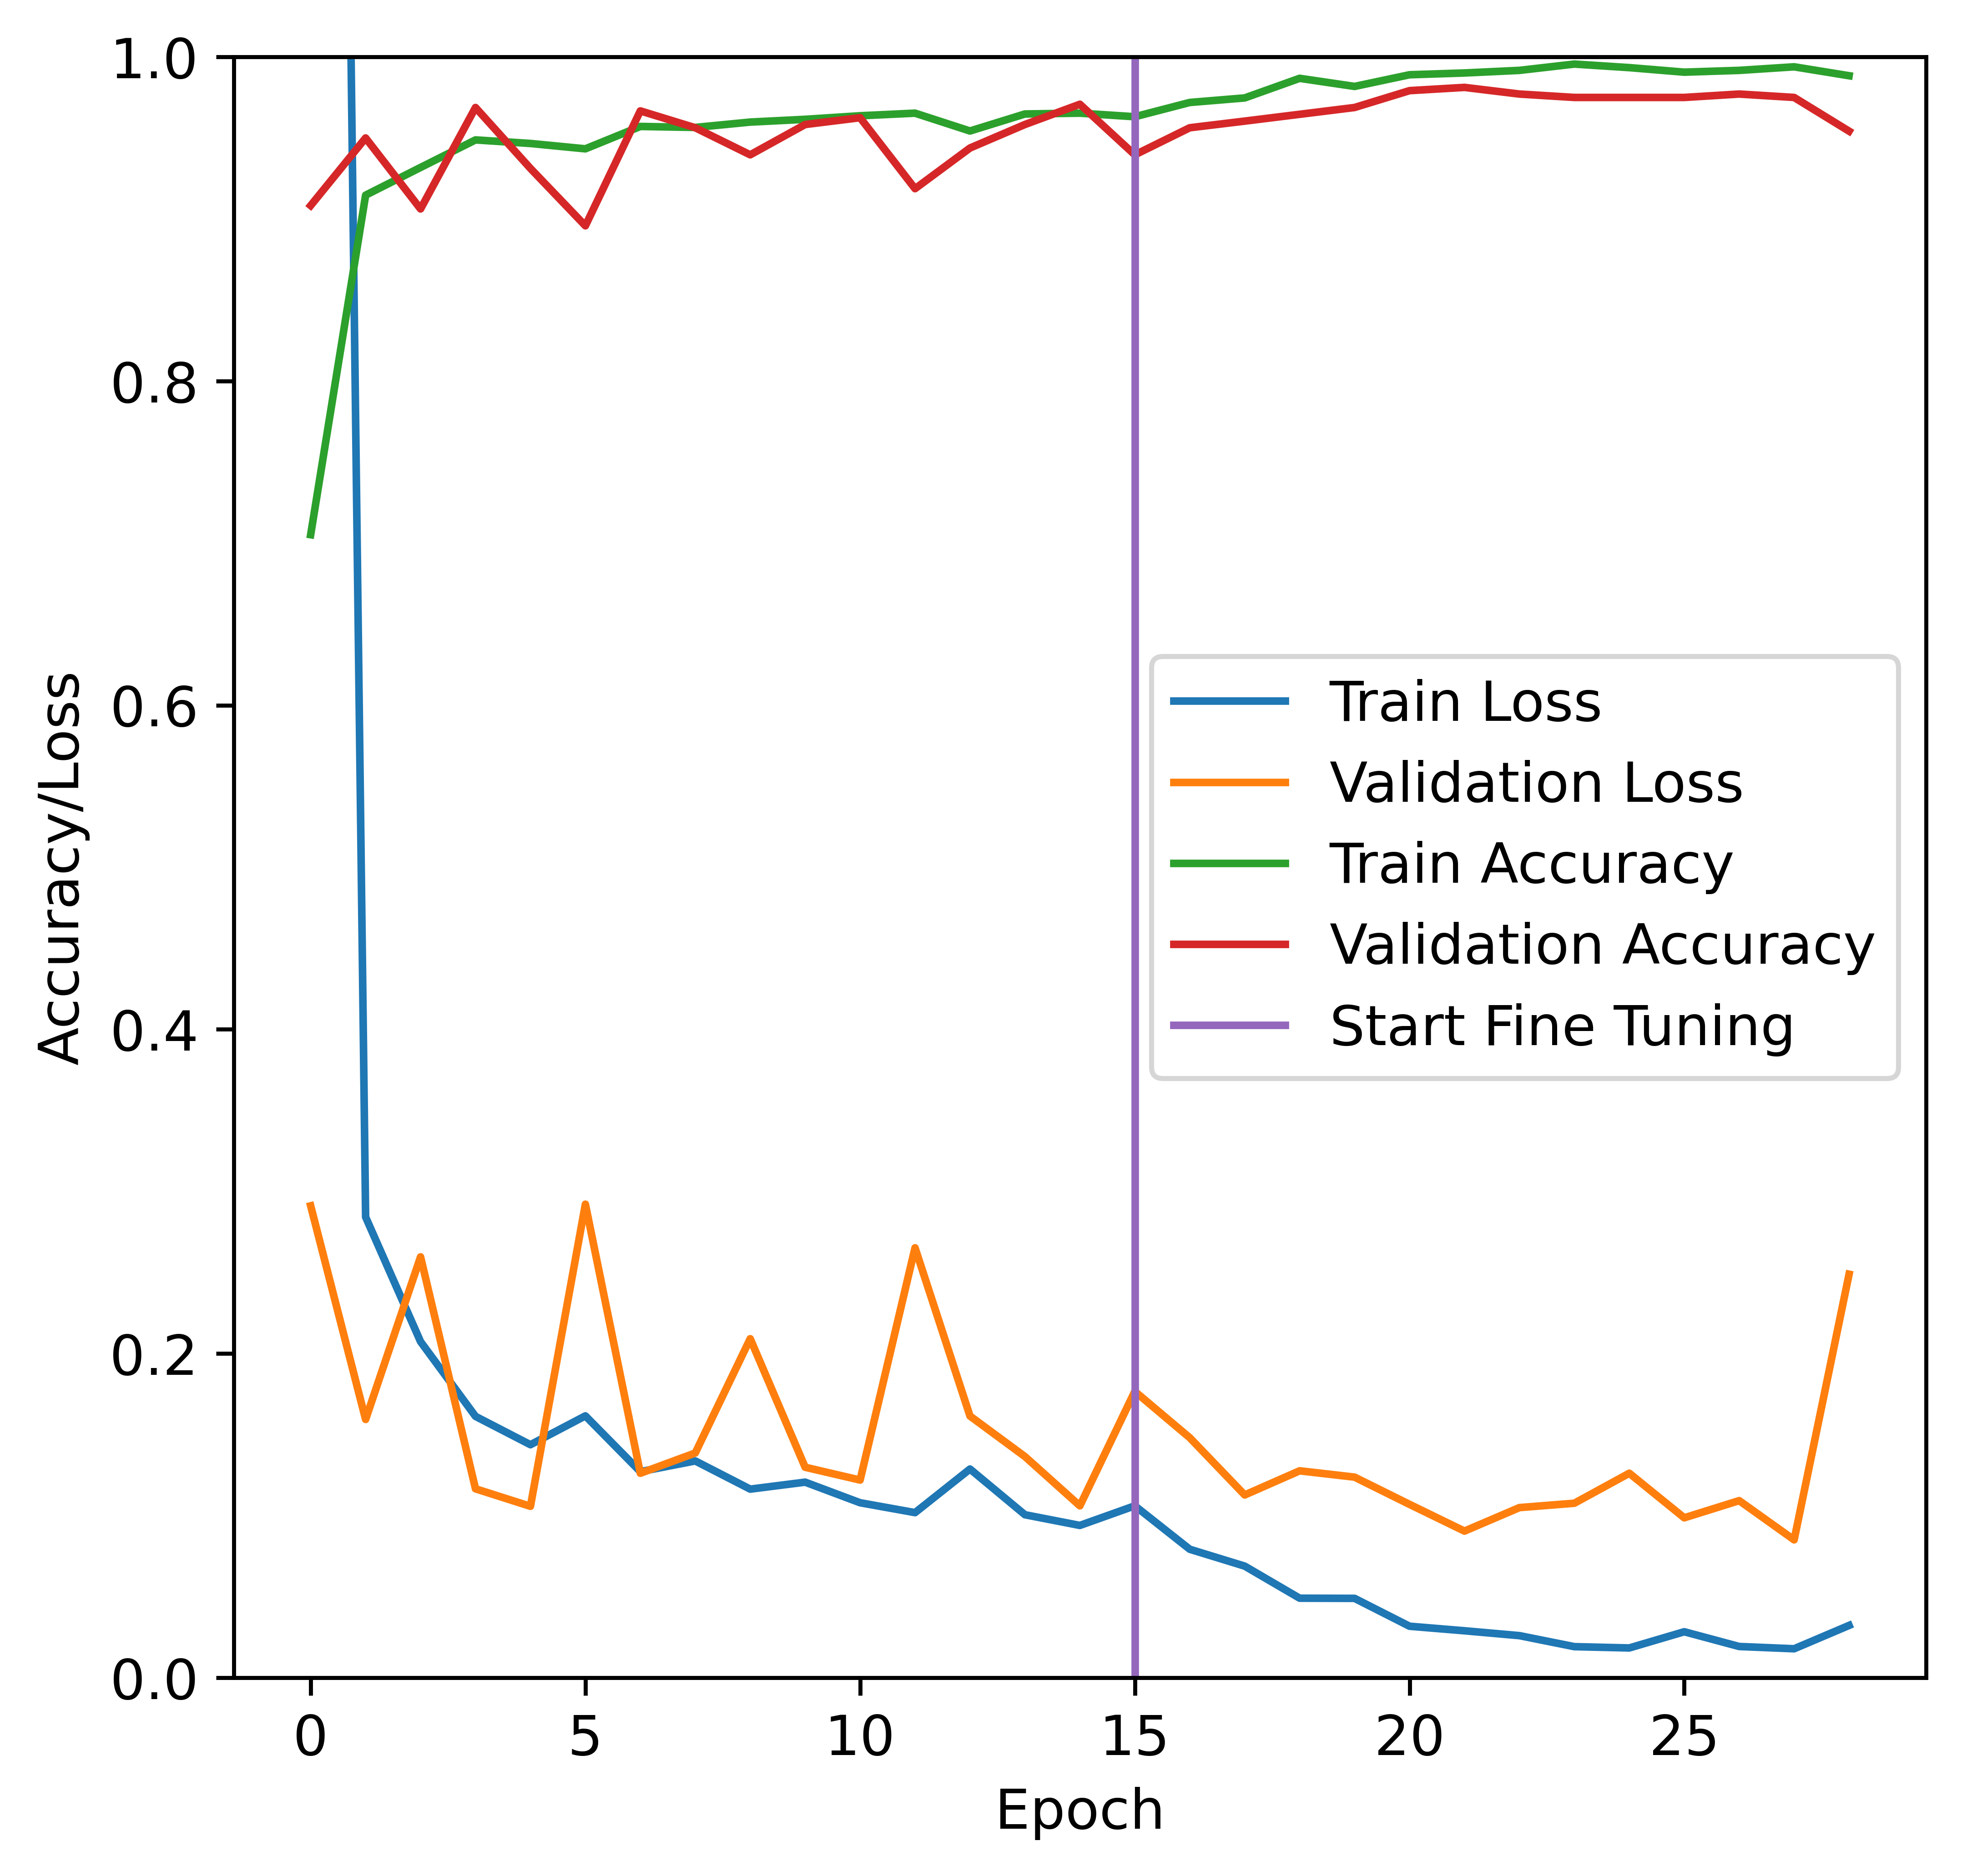

In [ ]:
plt.figure(figsize=(6,5.9), dpi=800)
plt.rcParams.update({'font.size': 11})
plt.plot(loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.plot(acc, label = 'Train Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0, 1.0])
initial_epoch = 15
plt.plot([initial_epoch,initial_epoch],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='middle right')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()